In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
from fastai.vision.all import *

In [11]:
import fastai
import torch
import numpy
import torchvision
print(torch.__version__)
print(fastai.__version__)
print(numpy.__version__)
print(torchvision.__version__)

2.6.0+cu124
2.7.19
1.26.4
0.21.0+cu124


In [3]:
from fastai.vision.all import *

path = Path("/kaggle/input/chest-xray-pneumonia")

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Define the blocks
    get_items=get_image_files, # Define the means of getting data into DataBlock
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    get_y=parent_label, # Define how to get the attributes (labels)
    item_tfms=Resize(460), # Define data transformations
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)] 
)

dls = dblock.dataloaders(path, bs=64)

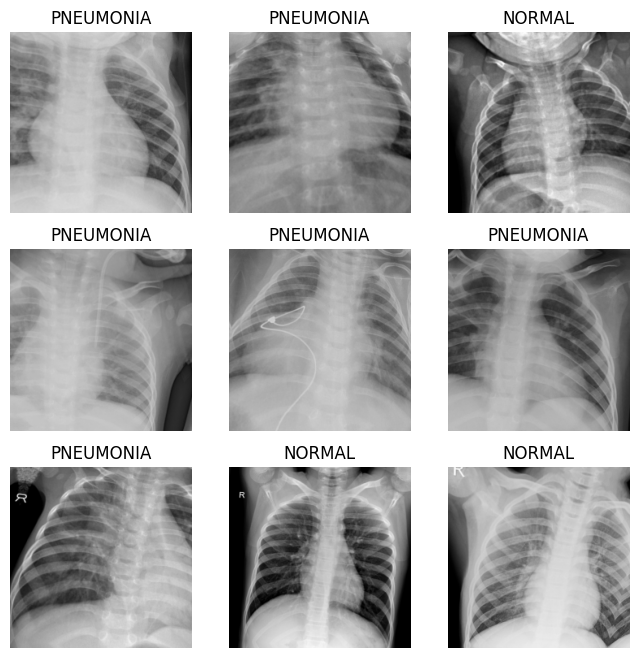

In [4]:
for i in range(5):
    print(dls.train_ds.items[i], dls.train_ds[i][1])

/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person268_virus_553.jpeg TensorCategory(1)
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person349_bacteria_1606.jpeg TensorCategory(1)
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0387-0001.jpeg TensorCategory(0)
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person38_bacteria_194.jpeg TensorCategory(1)
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person542_bacteria_2276.jpeg TensorCategory(1)


In [5]:
# Summarize the DataBlock
print("Veri tipi:", type(dls))
print("Sınıflar:", dls.vocab)
print("Sınıf sayısı:", dls.c)
print("Train örnek sayısı:", len(dls.train_ds))
print("Validation örnek sayısı:", len(dls.valid_ds))
for i in range(3):
    x, y = dls.train_ds[i]
    print(f"Resim boyutu: {x.size}, Etiket: {y}")
print("Item transforms:", dls.after_item)
print("Batch transforms:", dls.after_batch)
print(dblock)

Veri tipi: <class 'fastai.data.core.DataLoaders'>
Sınıflar: ['NORMAL', 'PNEUMONIA']
Sınıf sayısı: 2
Train örnek sayısı: 9370
Validation örnek sayısı: 2342
Resim boyutu: (1176, 736), Etiket: TensorCategory(1)
Resim boyutu: (1192, 760), Etiket: TensorCategory(1)
Resim boyutu: (1920, 1801), Etiket: TensorCategory(0)
Item transforms: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor
Batch transforms: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': 

In [6]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 188MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.370250,0.308715,0.900512,03:01


epoch,train_loss,valid_loss,accuracy,time
0,0.189544,0.119942,0.956447,02:56
1,0.110594,0.086511,0.968403,02:55
2,0.078780,0.068439,0.973527,02:56


In [6]:
learn = load_learner('/kaggle/input/base_model/other/default/1/pneumonia_resnet34.pkl')
# modeli kayıt edip tekrardan kullanırken dls i manuel olarak modele bağlmak gerekiyor ç

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


NameError: name 'learn' is not defined

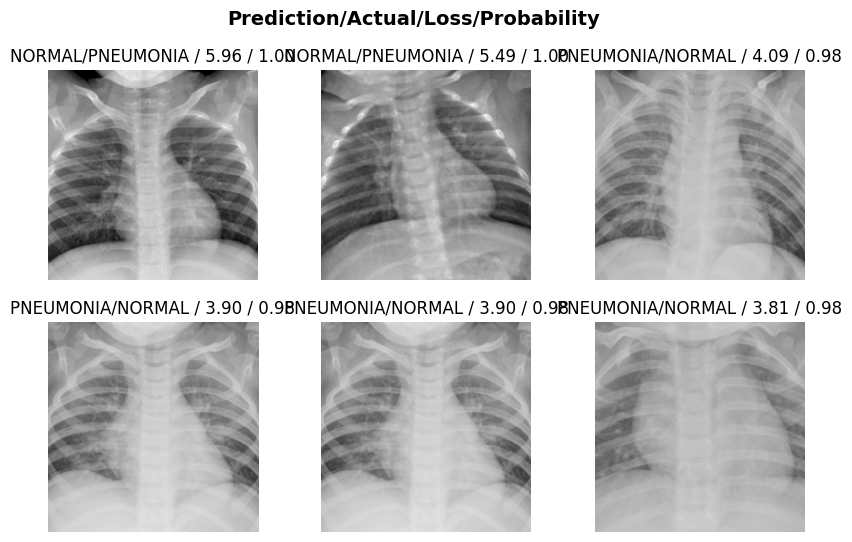

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(6, nrows=2, figsize=(10,6))

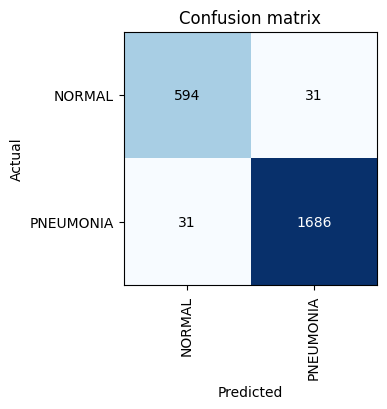

In [13]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=100)

In [9]:
# learn.export('/kaggle/working/pneumonia_resnet34.pkl')

## Learning Rate Finder (B.1 ve B.2)

Minimum loss lr: 2.2908675418875645e-07, Steepest descent lr: 1.3182567499825382e-06, Valley lr: 1.0964781722577754e-06


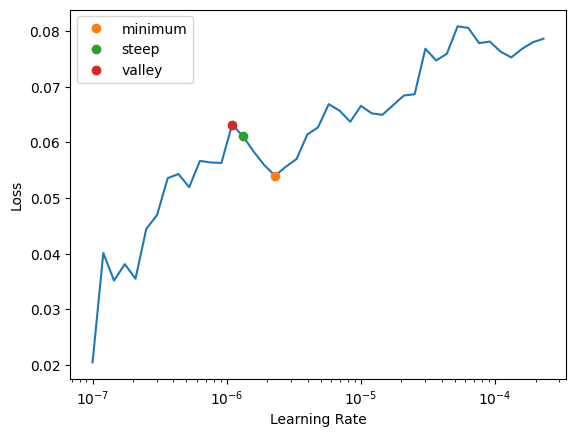

In [16]:
learn.dls = dls
lr_min, lr_steep, lr_valley = learn.lr_find(suggest_funcs=(minimum, steep, valley))
print(f"Minimum loss lr: {lr_min}, Steepest descent lr: {lr_steep}, Valley lr: {lr_valley}")

In [17]:
learn.fine_tune(3, base_lr=lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,0.072845,0.065371,0.974381,02:50


epoch,train_loss,valid_loss,accuracy,time
0,0.071153,0.072771,0.973100,02:48
1,0.068160,0.072780,0.972673,02:50
2,0.072493,0.066877,0.974381,02:52


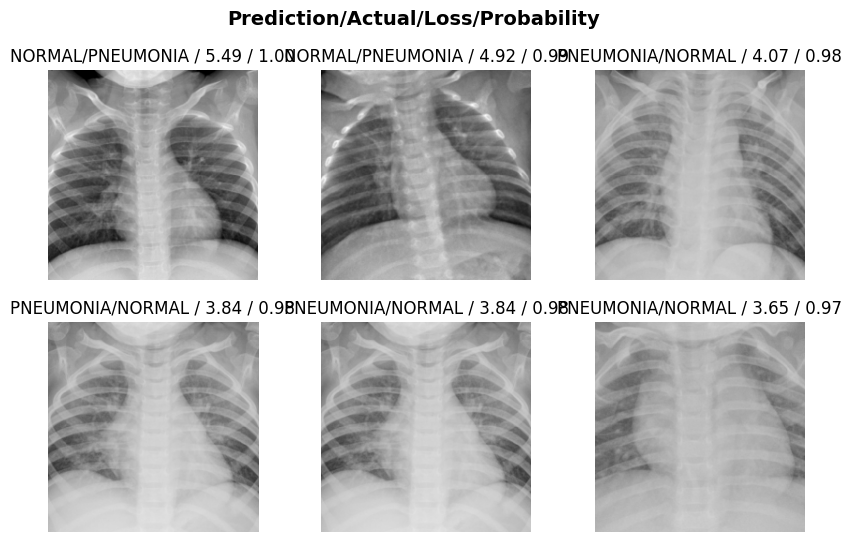

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(6, nrows=2, figsize=(10,6))

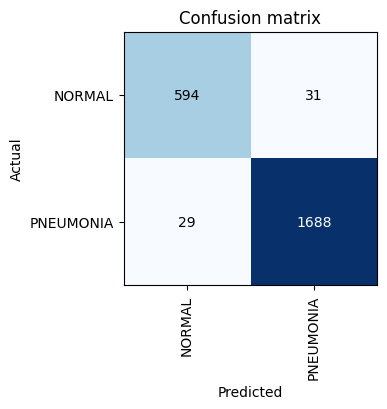

In [18]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=100)

In [19]:
learn.export('/kaggle/working/pneumonia_resnet34_lr_finetuned.pkl')

In [5]:
learn = load_learner('/kaggle/input/lr_finder_kullanlarak_oluturulanmodel/other/default/1/pneumonia_resnet34_lr_finetuned.pkl')


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [7]:
learn.dls = dls

In [8]:
learn.freeze()
learn.fit_one_cycle(1, lr_max=1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.069428,0.067799,0.973527,03:23


In [9]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))


epoch,train_loss,valid_loss,accuracy,time
0,0.063658,0.071616,0.976516,02:38
1,0.062871,0.059622,0.976943,02:32
2,0.065509,0.062341,0.978224,02:32
3,0.052850,0.056452,0.979078,03:02


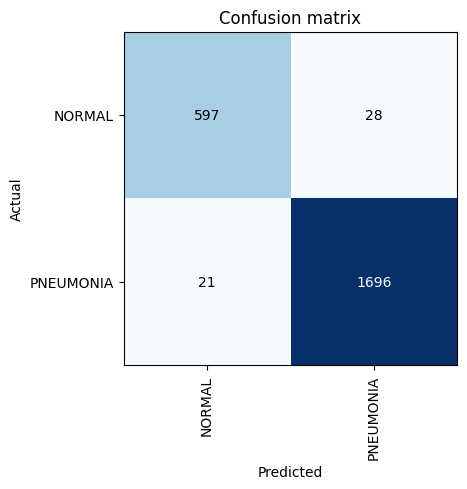

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [11]:
learn.export('/kaggle/working/pneumonia_resnet34_transfer.pkl')

 B.6.3 – Mixed Precision Eğitimi
Fastai'de to_fp16() fonksiyonu kullanılarak yapılır:
Faydaları:

Daha az GPU kullanımı

Daha hızlı eğitim

Özellikle büyük modellerde avantaj sağlar

Senin modelinde zorunlu değil ama iyi bir uygulama örneği olabilir.

In [13]:
# learn = learn.to_fp16()


In [4]:
learn = load_learner("/kaggle/input/finetuned/other/default/1/pneumonia_resnet34_transfer.pkl")

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [6]:
!pip install gradio fastai --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 100.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
from fastai.vision.all import *
import gradio as gr

learn = load_learner('/kaggle/input/finetuned/other/default/1/pneumonia_resnet34_transfer.pkl')

def predict(img):
    pred_class, pred_idx, probs = learn.predict(img)
    return { "NORMAL": float(probs[0]), "PNEUMONIA": float(probs[1]) }

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="Pneumonia Detection from Chest X-ray",
    description="Upload a chest X-ray image to get prediction."
)


In [10]:
demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://f6872cca30640f4304.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
learn.export('/kaggle/working/pneumonia_resnet34_transfer.pkl')

In [1]:
import shutil

# Model dosyasını /kaggle/working klasörüne kopyala
shutil.copy('/kaggle/input/finetuned/other/default/1/pneumonia_resnet34_transfer.pkl',
            '/kaggle/working/pneumonia_resnet34_transfer.pkl')


'/kaggle/working/pneumonia_resnet34_transfer.pkl'

In [1]:
torch --version 

NameError: name 'torch' is not defined